<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Flatten-and-Split-the-data-into-training-and-test-sets" data-toc-modified-id="Flatten-and-Split-the-data-into-training-and-test-sets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Flatten and Split the data into training and test sets</a></span></li><li><span><a href="#Building-the-model" data-toc-modified-id="Building-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building the model</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train</a></span></li></ul></div>

In [1]:
# To obtain reproducible results
import sys
sys.path.insert(0, '/home/abanihi/devel/myprojects/deep-learning/')
from utils import reproducibility

/home/abanihi/anaconda3/envs/autoe/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import xarray as xr

# Load the data 

In [3]:
access_pr_file = '/home/abanihi/devel/deepclimate/deepclimate-rd/sample_aos_data/pr_Amon_ACCESS1-3_historical_r1i1p1_200101-200512.nc'

In [4]:
dset = xr.open_dataset(access_pr_file)

In [5]:
pr = dset['pr'] * 86400
pr

<xarray.DataArray 'pr' (time: 60, lat: 145, lon: 192)>
array([[[0.19356 , 0.19356 , ..., 0.193565, 0.193565],
        [0.144753, 0.145445, ..., 0.143843, 0.144203],
        ...,
        [0.234199, 0.224581, ..., 0.243426, 0.23944 ],
        [0.193997, 0.193997, ..., 0.193997, 0.193997]],

       [[0.407444, 0.407444, ..., 0.407334, 0.407334],
        [0.357676, 0.355279, ..., 0.362809, 0.360405],
        ...,
        [0.541897, 0.545767, ..., 0.537055, 0.53841 ],
        [0.548726, 0.548726, ..., 0.548726, 0.548726]],

       ...,

       [[0.22288 , 0.22288 , ..., 0.222746, 0.222746],
        [0.198965, 0.197357, ..., 0.202459, 0.201638],
        ...,
        [1.108785, 1.101874, ..., 1.127764, 1.119411],
        [0.899674, 0.899674, ..., 0.899674, 0.899674]],

       [[0.120204, 0.120204, ..., 0.120176, 0.120176],
        [0.077715, 0.077859, ..., 0.077662, 0.077223],
        ...,
        [0.641761, 0.651492, ..., 0.628137, 0.637484],
        [0.578696, 0.578696, ..., 0.578696, 0.578

In [6]:
data = pr.values
data.shape

(60, 145, 192)

# Flatten and Split the data into training and test sets

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

In [8]:
data = data.reshape((len(data), np.prod(data.shape[1:])))
x_train, x_test = train_test_split(data, test_size=0.3)

In [9]:
x_train.shape, x_test.shape

((42, 27840), (18, 27840))

# Building the model

In [10]:
from keras import layers
from keras import models
from keras import regularizers
from keras import losses
from keras import callbacks
from math import sqrt

In [11]:
activity_reg = regularizers.l1(0.)
kernel_reg = regularizers.l1(0.)

In [12]:
image_dim = x_train.shape[1]
image_dim

27840

In [13]:
encoded_dim = 42

In [14]:
# this the input placeholder
input_img = layers.Input(shape=(image_dim, ))

In [15]:
encoded = layers.Dense(
    encoded_dim,
    activation='selu',
    activity_regularizer=activity_reg,
    kernel_regularizer=kernel_reg,
    name="encoded")(input_img)

In [16]:
# Decoded is thelossy reconstruction of the input
decoded = layers.Dense(
    image_dim, activation='sigmoid', name="decoded")(encoded)

In [17]:
# This model maps an input to its reconstruction 
model = models.Model(input_img, decoded)

In [18]:
# This model maps an input to tis encoded representation
encoder = models.Model(input_img, encoded)

In [19]:
# Create a placeholder for an encoded (324-dimensional) input
encoded_input = layers.Input(shape=(encoded_dim, ))

In [20]:
# Retrieve the last layer of the autoencoder model
decoded_layer = model.layers[-1]

In [21]:
# Create the decoder model
decoder = models.Model(encoded_input, decoded_layer(encoded_input))

In [22]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 27840)             0         
_________________________________________________________________
encoded (Dense)              (None, 42)                1169322   
Total params: 1,169,322
Trainable params: 1,169,322
Non-trainable params: 0
_________________________________________________________________


In [23]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 42)                0         
_________________________________________________________________
decoded (Dense)              (None, 27840)             1197120   
Total params: 1,197,120
Trainable params: 1,197,120
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 27840)             0         
_________________________________________________________________
encoded (Dense)              (None, 42)                1169322   
_________________________________________________________________
decoded (Dense)              (None, 27840)             1197120   
Total params: 2,366,442
Trainable params: 2,366,442
Non-trainable params: 0
_________________________________________________________________


In [25]:
callbacks_list = [callbacks.EarlyStopping(monitor='loss', patience=10)]

# Train

In [26]:
model.compile(optimizer="rmsprop", loss = losses.mse)

In [27]:
%%time
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=16,
    shuffle=True,
    callbacks=callbacks_list,
    validation_data=(x_test, x_test))

Train on 42 samples, validate on 18 samples
Epoch 1/50
42/42 [==============================] - 1s 21ms/step - loss: 15.1418 - val_loss: 13.6126
Epoch 2/50
42/42 [==============================] - 0s 3ms/step - loss: 13.6301 - val_loss: 13.4995
Epoch 3/50
42/42 [==============================] - 0s 3ms/step - loss: 13.5577 - val_loss: 13.4763
Epoch 4/50
42/42 [==============================] - 0s 3ms/step - loss: 13.5390 - val_loss: 13.4655
Epoch 5/50
42/42 [==============================] - 0s 3ms/step - loss: 13.5296 - val_loss: 13.4561
Epoch 6/50
42/42 [==============================] - 0s 3ms/step - loss: 13.5219 - val_loss: 13.4520
Epoch 7/50
42/42 [==============================] - 0s 3ms/step - loss: 13.5169 - val_loss: 13.4463
Epoch 8/50
42/42 [==============================] - 0s 3ms/step - loss: 13.5112 - val_loss: 13.4412
Epoch 9/50
42/42 [==============================] - 0s 3ms/step - loss: 13.5072 - val_loss: 13.4377
Epoch 10/50
42/42 [==============================] - 0s

In [28]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
%matplotlib inline

In [29]:
def predict_test():
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    print("Mean activations: {}".format(encoded_imgs.mean()))

    indices = np.random.choice(len(x_test), 5)

    n = len(indices)

    fig = plt.figure(figsize=(20, 4))

    rows = 3

    side = int(np.sqrt(encoded_dim))

    for i in range(n):

        # display original
        ax = plt.subplot(rows, n, i + 1)
        plt.imshow(x_test[indices[i]].reshape(145, 192))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display encoding
        ax = plt.subplot(rows, n, i + 1 + n)
        plt.imshow(((encoded_imgs[indices[i]] + 1) / 2).reshape(6, 7))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(rows, n, i + 1 + 2 * n)
        plt.imshow(decoded_imgs[indices[i]].reshape(145, 192))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Mean activations: 13.819934844970703


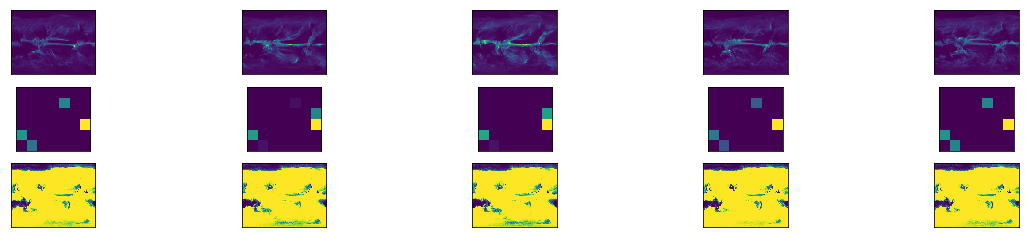

In [30]:
predict_test()

In [31]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


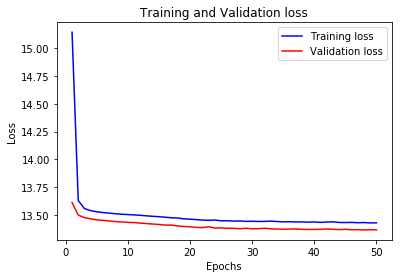

In [32]:
plot_history(history)

In [33]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs.shape


(18, 27840)

In [34]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(x_test, decoded_imgs)
print(mse)

13.366407136413825


In [35]:
%load_ext version_information
%version_information keras, tensorflow, numpy , matplotlib

Software versions
Python 3.6.4 64bit [GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
IPython 6.2.1
OS Linux 4.4.0 53 generic x86_64 with debian stretch sid
keras 2.1.3
tensorflow 1.4.1
numpy 1.14.0
matplotlib 2.1.2
Thu Jan 25 13:15:41 2018 CST